## BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scikitplot as skplt

from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset_UNSW1_TESTING = pd.read_csv("UNSW_NB15_testing.csv")
dataset_UNSW1_TRAINING = pd.read_csv("UNSW_NB15_training.csv")
dataset_marge = pd.merge(
                    dataset_UNSW1_TESTING, 
                    dataset_UNSW1_TRAINING, 
                    how = 'outer').drop(axis=1, columns=['proto', 'service', 'state'])
attack_dados = dataset_marge['attack_cat'].values
dataset_marge = dataset_marge.drop(axis=1, columns=['attack_cat'])

In [49]:
dataset_UNSW1_TRAINING.shape

(82332, 45)

In [3]:
dataset_marge.head()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,1,0.121478,6,4,258,172,74.087490,252,254,14158.942380,...,1,1,1,0,0,0,1,1,0,0
1,2,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,...,1,1,2,0,0,0,1,6,0,0
2,3,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,...,1,1,3,0,0,0,2,6,0,0
3,4,1.681642,12,12,628,770,13.677108,62,252,2740.178955,...,1,1,3,1,1,0,2,1,0,0
4,5,0.449454,10,6,534,268,33.373826,254,252,8561.499023,...,2,1,40,0,0,0,2,39,0,0


In [4]:
# Dimensão do dataset
dataset_marge.shape

(257673, 41)

In [5]:
# Verificando os tipos de dados e distribuição nula/não nula
dataset_marge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 257672
Data columns (total 41 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   spkts              257673 non-null  int64  
 3   dpkts              257673 non-null  int64  
 4   sbytes             257673 non-null  int64  
 5   dbytes             257673 non-null  int64  
 6   rate               257673 non-null  float64
 7   sttl               257673 non-null  int64  
 8   dttl               257673 non-null  int64  
 9   sload              257673 non-null  float64
 10  dload              257673 non-null  float64
 11  sloss              257673 non-null  int64  
 12  dloss              257673 non-null  int64  
 13  sinpkt             257673 non-null  float64
 14  dinpkt             257673 non-null  float64
 15  sjit               257673 non-null  float64
 16  dj

In [6]:
# Verifica se há valores nulus
dataset_marge.isnull().sum()

id                   0
dur                  0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
label                0
dtype: int64

In [7]:
# Verificando a distribuição de valores numéricos no conjunto de dados
dataset_marge.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,72811.823858,1.246715,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,...,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,0.639077
std,48929.917641,5.974305,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,...,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,0.480269
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,32210.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,64419.000000,0.004285,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,110923.000000,0.685777,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,...,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,1.000000
max,175341.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,...,59.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [8]:
# Verifica a distribuição de classe da variável de destino a LABEL
dataset_marge["label"].value_counts()

1    164673
0     93000
Name: label, dtype: int64

0  36.1 %
1  63.9 %


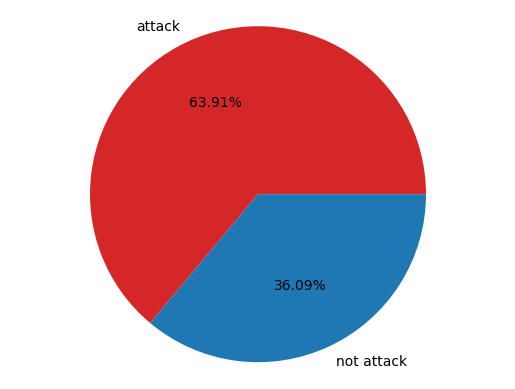

In [9]:
# Verificando a distribuição de classe da variável de destino em porcentagem

classes=dataset_marge['label'].value_counts()
not_attack=round(classes[0]/dataset_marge['label'].count()*100,1)
attack=round(classes[1]/dataset_marge['label'].count()*100,1)

print("0 ", not_attack, "%")
print("1 ", attack, "%")
label_cor = ['tab:red', 'tab:blue']
plt.pie(dataset_marge.label.value_counts(), colors=label_cor ,labels=['attack', 'not attack'], autopct='%0.2f%%')
plt.axis('equal')
plt.show()

In [10]:
# # Verificando a correlação no mapa de calor
# corr = dataset_marge.corr()
# plt.figure(figsize=(24,18))
# sns.heatmap(corr, cmap="coolwarm", annot=True)
# plt.show()

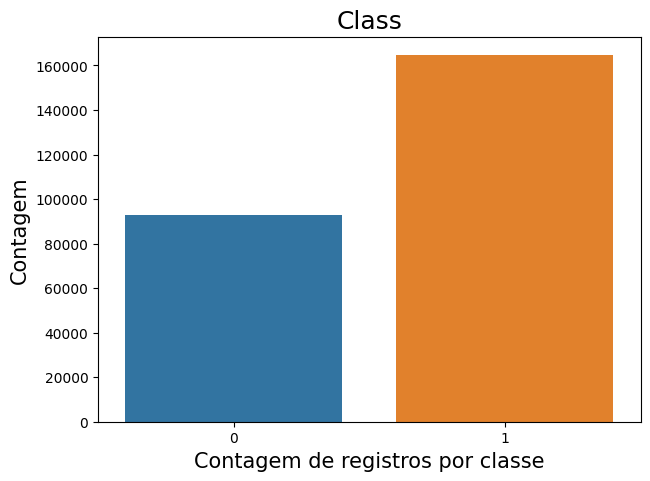

In [11]:
# Gráfico de barras para o número e a porcentagem de attacks vs não attacks 
plt.figure(figsize=(7,5))
sns.countplot(x=dataset_marge['label'])
plt.title("Class", fontsize=18)
plt.xlabel("Contagem de registros por classe", fontsize=15)
plt.ylabel("Contagem", fontsize=15)
plt.show()

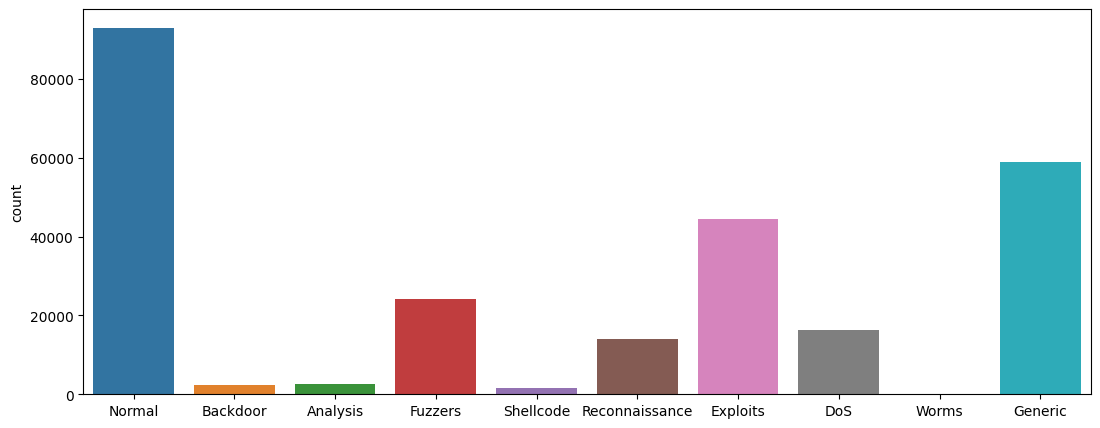

In [12]:
# Classe attack_cat mostrando os tipos de ataques existentes
plt.figure(figsize=(13,5))
sns.countplot(x=attack_dados)
plt.show()

## <center> <a name="p4-1">DIVIDINDO OS DADOS EM TREINO E TESTE</a>

In [13]:
# Separando as fetures
Y_dados= dataset_marge['label']
X_dados = dataset_marge.drop(['label'], axis=1)

In [14]:
# Dimenssão de Y_dados
Y_dados.shape

(257673,)

In [15]:
# Dimenssão de Y_dados
X_dados.shape

(257673, 40)

In [16]:
# Dividindo o conjunto de dados usando a divisão de teste de treinamento
X_train, X_test, y_train, y_test = train_test_split(X_dados, Y_dados, random_state=1, test_size=0.3)

In [17]:
# Quantidades de transações positivas
print(np.sum(Y_dados))
print(np.sum(y_train))
print(np.sum(y_test))

164673
115349
49324


In [18]:
# Atribuindo todas as colunas de X_dados em cols como lista
cols = list(X_dados.columns.values)

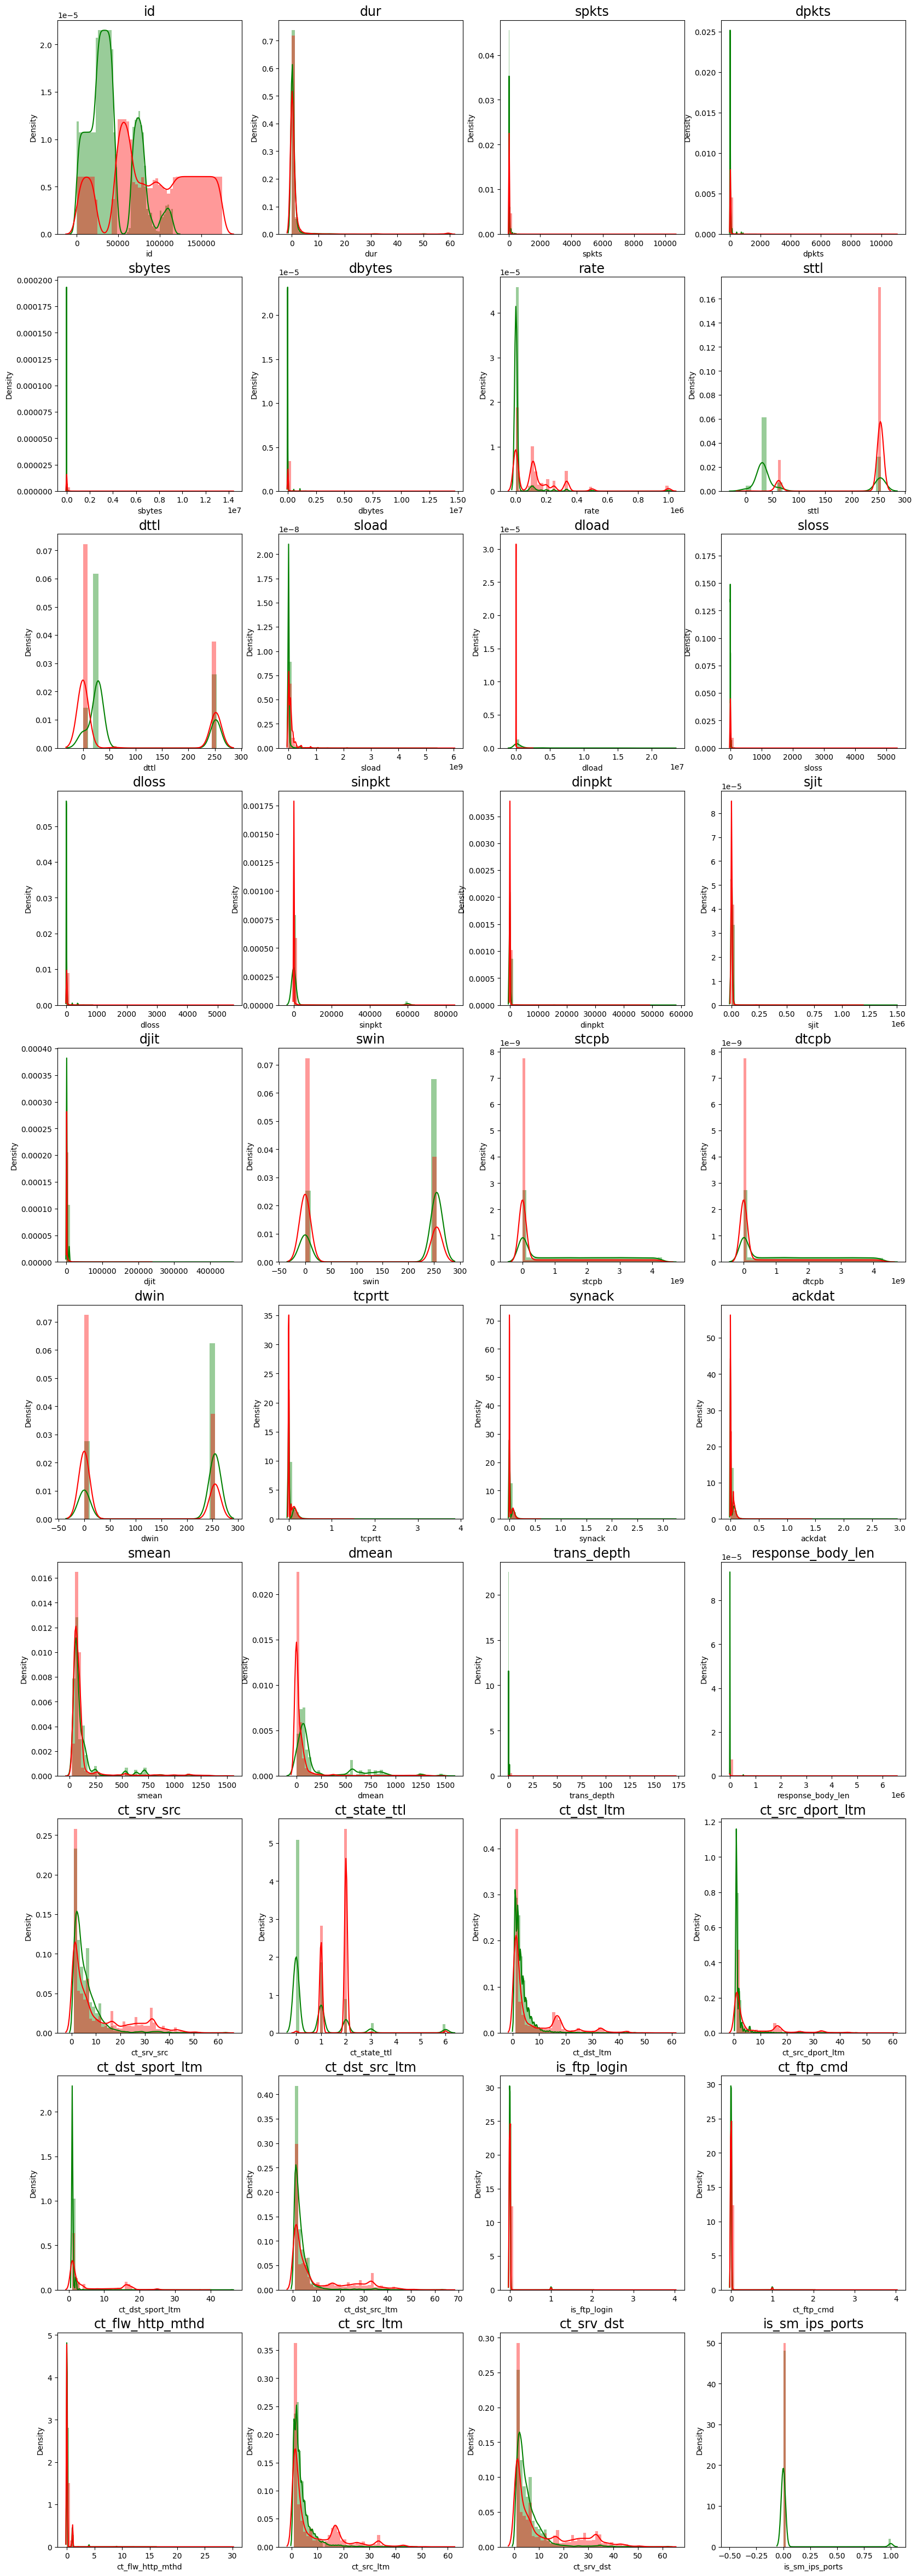

In [19]:
# Aqui mostra a distribuição por coluna dos dados, verde quer dizer que é uma reansação légitima, o `vermelho diz o contrário
normal_transation = dataset_marge.label == 0
fraud_detection = dataset_marge.label == 1

plt.figure(figsize=(20, 60))
for n, col in enumerate(cols):
    plt.subplot(10,4,n+1)
    sns.distplot(X_dados[col][normal_transation], color='green')
    sns.distplot(X_dados[col][fraud_detection], color='red')
    plt.title(col, fontsize=17)
plt.show()

## <center><a name="p4-1">CONSTRUINDO OS MODELOS</a></center>

In [20]:
# Crie um dataframe para armazenar resultados
Results = pd.DataFrame(columns=['Methodology','Model','Accuracy','roc_value','threshold'])

In [21]:
# Função para plotar a matreix de confusão
def confusion_matrix_plot(y_test, pred_test):
    conf_m = confusion_matrix(y_test, pred_test)
    print("VN = VERDADEIRO NEGATIVO")
    print("FP = FALSO POSITIVO")
    print("FN = FALSO NEGATIVO")
    print("TP = VERDADEIRO POSITIVO")
    plt.clf()
    plt.imshow(conf_m, interpolation='nearest', cmap=plt.cm.Accent)
    categoryNames = ['not-attack','attack'] 
    plt.title('Matriz de Confusão - Dados de teste')
    plt.ylabel('Rótulo verdadeiro')
    plt.xlabel('Rótulo previsto')
    ticks = np.arange(len(categoryNames))
    plt.xticks(ticks, categoryNames, rotation=45)
    plt.yticks(ticks, categoryNames)
    s = [['TN','FP'], ['FN', 'TP']]
  
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(conf_m[i][j]),fontsize=12)
    plt.show()

In [22]:
# função para ajustar e prever em um modelo XGBoost
def XGBoost_Model(Results, Methodology, X_train, y_train, X_test, y_test ):
  
    # Avalie o modelo XGboost
    XGBmodel = XGBClassifier(random_state=42)
    XGBmodel.fit(X_train, y_train)
    y_pred = XGBmodel.predict(X_test)
    XGB_test_score = XGBmodel.score(X_test, y_test)
    print('Model Accuracy: {0}'.format(XGB_test_score))

    # Chamada da função da matriz de confusão
    print("Confusion Matrix")
    confusion_matrix_plot(y_test, y_pred)
    print("classification Report")
    print(classification_report(y_test, y_pred))
    
  # Probabilidades para cada classe
    XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

  # Calcula roc auc
    XGB_roc_value = roc_auc_score(y_test, XGB_probs)

    print("XGboost roc_value: {0}" .format(XGB_roc_value))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
    threshold = thresholds[np.argmax(tpr-fpr)]
    print("XGBoost threshold: {0}".format(threshold))
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC para o conjunto de dados de teste:",'{:.1%}'.format(roc_auc))
    plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()
  
    df_Results = Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'XGBoost','Accuracy': XGB_test_score,'roc_value': XGB_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

    return df_Results


In [23]:
# Cria uma função comum para ajustar e prever em um modelo Random Forest
def Random_Forest_Modelo(Results, Methodology, X_train, y_train, X_test, y_test ):
  # Avalie o modelo Random Forest

  # Modelo com 100 árvores
    Random_F_model = RandomForestClassifier(n_estimators=100, 
                                bootstrap = True,
                                max_features = 'sqrt', 
                                random_state = 42)

  # Ajustar aos dados de treinamento
    Random_F_model.fit(X_train, y_train)
    RF_test_score = Random_F_model.score(X_test, y_test)
    Random_F_model.predict(X_test)

    print('Model Accuracy: {0}'.format(RF_test_score))


  # Previsões de classe reais
    rf_predictions = Random_F_model.predict(X_test)

    print("Matriz de Confusão")
    confusion_matrix_plot(y_test, rf_predictions)
    print("Relatório de Classificação")
    print(classification_report(y_test, rf_predictions))

  # Probabilidades para cada class
    rf_probs = Random_F_model.predict_proba(X_test)[:, 1]

  # Calcular roc auc
    roc_value = roc_auc_score(y_test, rf_probs)

    print("Random Forest roc_value: {0}" .format(roc_value))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_probs)
    threshold = thresholds[np.argmax(tpr-fpr)]
    print("Random Forest threshold: {0}".format(threshold))
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
    plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()
  
    df_Results = Results.append(pd.DataFrame(
      {
          'Methodology': Methodology,
          'Model': 
          'Random Forest',
          'Accuracy': RF_test_score,
          'roc_value': roc_value,
          'threshold': threshold
      }, index=[0]),ignore_index= True)

    return df_Results

In [24]:
# Função comum para ajustar e prever em um modelo KNN
def KNN_Model(df_Results,Methodology, X_train,y_train, X_test, y_test ):

  # Ajustar o modelo com conjunto de dados de train
    knn = KNeighborsClassifier(n_neighbors = 5, n_jobs=16)
    knn.fit(X_train,y_train)
    score = knn.score(X_test,y_test)
    print("score do modelo")
    print(score)
  
  # Accuracy
    y_pred = knn.predict(X_test)
    KNN_Accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)
    print("Matrix de confusão")
    confusion_matrix_plot(y_test, y_pred)
    print("classification Report")
    print(classification_report(y_test, y_pred))


    knn_probs = knn.predict_proba(X_test)[:, 1]

  # Calcula roc auc
    knn_roc_value = roc_auc_score(y_test, knn_probs)
    print("KNN roc_value: {0}" .format(knn_roc_value))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_probs)
    threshold = thresholds[np.argmax(tpr-fpr)]
    print("KNN threshold: {0}".format(threshold))

    roc_auc = metrics.auc(fpr, tpr)
    print("ROC para o conjunto de dados de teste",'{:.1%}'.format(roc_auc))
    plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()
  
    df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'KNN','Accuracy': score,'roc_value': knn_roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

    return df_Results

In [25]:
# Cria uma função comum para ajustar e prever em um modelo SVM
def SVM(Results, Methodology, X_train,y_train, X_test, y_test ):
    
  # Avalie o modelo SVM com o modelo de kernel sigmóide
    clf = SVC(kernel='sigmoid', random_state=42)
    clf.fit(X_train,y_train)
    y_pred_SVM = clf.predict(X_test)
    SVM_Score = accuracy_score(y_test,y_pred_SVM)
    print("accuracy_score : {0}".format(SVM_Score))
    print("Confusion Matrix")
    confusion_matrix_plot(y_test, y_pred_SVM)
    print("classification Report")
    print(classification_report(y_test, y_pred_SVM))

  # Executar classificador
    classifier = SVC(kernel='sigmoid' , probability=True)
    svm_probs = classifier.fit(X_train, y_train).predict_proba(X_test)[:, 1]

  # Calcula roc auc
    roc_value = roc_auc_score(y_test, svm_probs)
  
    print("SVM roc_value: {0}" .format(roc_value))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, svm_probs)
    threshold = thresholds[np.argmax(tpr-fpr)]
    print("SVM threshold: {0}".format(threshold))
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
    plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()
  
    df_Results = Results.append(pd.DataFrame({'Methodology': Methodology,'Model': 'SVM','Accuracy': SVM_Score,'roc_value': roc_value,'threshold': threshold}, index=[0]),ignore_index= True)

    return df_Results

## <center><a name="p4-1">EXECUTANDO VALIDAÇÃO CRUZADA COM REPEATEDKFOLD</a></center>
## <center><a name="p4-1">+</a></center>
## <center><a name="p4-1">SMOTE</a></center>

In [26]:
# Rodando o conjunto de dados com SMOTE e RepeatedKFold
from sklearn.model_selection import RepeatedKFold
from imblearn.over_sampling import SMOTE
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)
# X_dados é o conjunto de recursos e Y_dados é o alvo
cont = 0
for train_index, test_index in rkf.split(X_dados,Y_dados):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X_dados.iloc[train_index], X_dados.iloc[test_index]
    y_train_cv, y_test_cv = Y_dados.iloc[train_index], Y_dados.iloc[test_index]
    ROS = SMOTE(random_state=0)
    X_train_SMOTE, y_train_SMOTE= ROS.fit_resample(X_train_cv, y_train_cv)
    cont += 1
print("Total de repetições: ", cont)

TRAIN: [     0      1      2 ... 257670 257671 257672] TEST: [     4      8     27 ... 257650 257659 257669]
TRAIN: [     0      1      2 ... 257669 257670 257671] TEST: [    10     15     16 ... 257667 257668 257672]
TRAIN: [     0      1      2 ... 257669 257671 257672] TEST: [     6      9     12 ... 257654 257663 257670]
TRAIN: [     2      3      4 ... 257670 257671 257672] TEST: [     0      1      5 ... 257655 257661 257662]
TRAIN: [     0      1      4 ... 257669 257670 257672] TEST: [     2      3      7 ... 257658 257664 257671]
TRAIN: [     0      1      2 ... 257669 257670 257671] TEST: [    17     30     32 ... 257653 257664 257672]
TRAIN: [     1      3      4 ... 257670 257671 257672] TEST: [     0      2     15 ... 257666 257667 257669]
TRAIN: [     0      1      2 ... 257669 257671 257672] TEST: [     3      5     12 ... 257661 257668 257670]
TRAIN: [     0      1      2 ... 257669 257670 257672] TEST: [     6     10     13 ... 257656 257660 257671]
TRAIN: [     0     

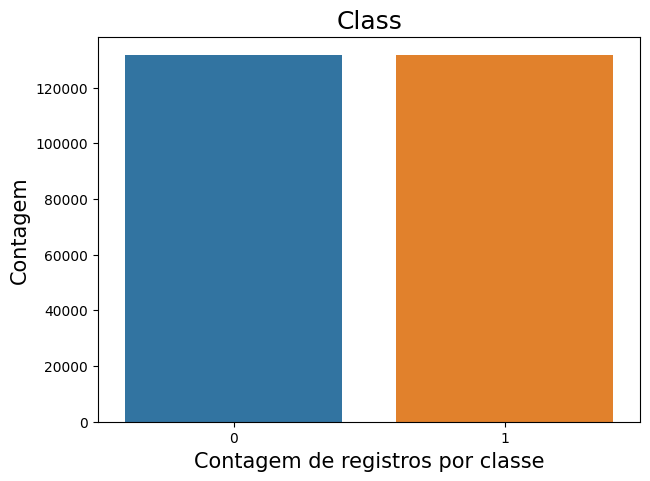

In [27]:
# Gráfico de barras para o número e a porcentagem de transações fraudulentas versus não fraudulentas
plt.figure(figsize=(7,5))
sns.countplot(x=y_train_SMOTE)
plt.title("Class", fontsize=18)
plt.xlabel("Contagem de registros por classe", fontsize=15)
plt.ylabel("Contagem", fontsize=15)
plt.show()

XGBoost Model
Model Accuracy: 0.9888811270229363
Confusion Matrix
VN = VERDADEIRO NEGATIVO
FP = FALSO POSITIVO
FN = FALSO NEGATIVO
TP = VERDADEIRO POSITIVO


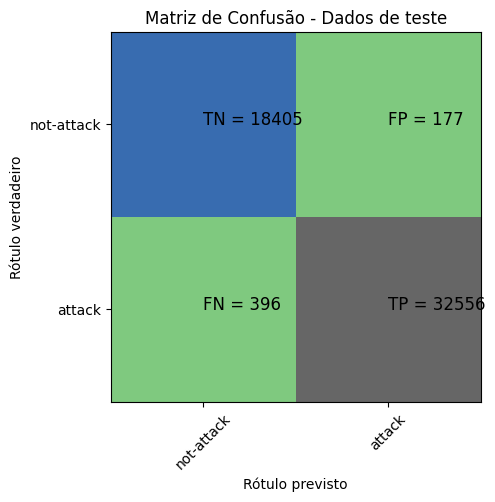

classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18582
           1       0.99      0.99      0.99     32952

    accuracy                           0.99     51534
   macro avg       0.99      0.99      0.99     51534
weighted avg       0.99      0.99      0.99     51534

XGboost roc_value: 0.9993917557640812
XGBoost threshold: 0.5462886691093445
ROC para o conjunto de dados de teste: 99.9%


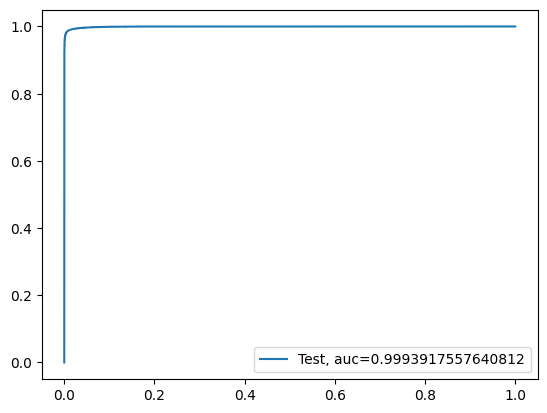

------------------------------------------------------------
Tempo gasto pelo modelo em Segundos: 5.83
Tempo gasto pelo modelo em Minutos: 0.1
Tempo gasto pelo modelo em Horas: 0.0
------------------------------------------------------------


In [31]:
# Rodando XGBoost Model
import time
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
print("XGBoost Model")
start_time = time.time()
df_Results = XGBoost_Model(Results,"SMOTE COM RepeatedKFold Cross Validation",X_train_cv, y_train_cv, X_test_cv, y_test_cv)
segundos = round((time.time() - start_time),2)
minutos = round((time.time() - start_time) / 60, 2)
horas = round(((time.time() - start_time) / 60) / 60, 2)
print('-'*60 )
print("Tempo gasto pelo modelo em Segundos: %s" % segundos)
print("Tempo gasto pelo modelo em Minutos: %s" % minutos)
print("Tempo gasto pelo modelo em Horas: %s" % horas)
print('-'*60 )

In [32]:
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,SMOTE COM RepeatedKFold Cross Validation,XGBoost,0.988881,0.999392,0.546289


In [33]:
df1 = df_Results

Random Forest Model
Model Accuracy: 0.9839135328132883
Matriz de Confusão
VN = VERDADEIRO NEGATIVO
FP = FALSO POSITIVO
FN = FALSO NEGATIVO
TP = VERDADEIRO POSITIVO


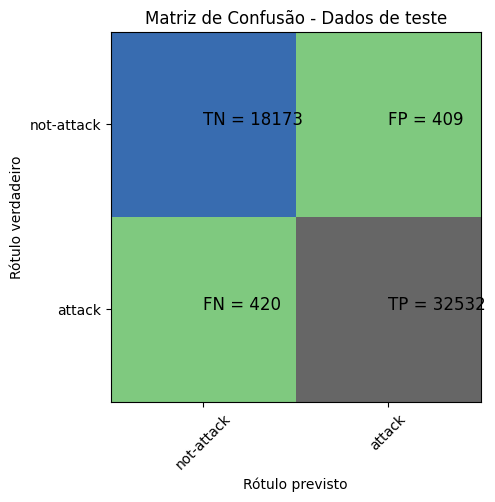

Relatório de Classificação
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18582
           1       0.99      0.99      0.99     32952

    accuracy                           0.98     51534
   macro avg       0.98      0.98      0.98     51534
weighted avg       0.98      0.98      0.98     51534

Random Forest roc_value: 0.9986356862448287
Random Forest threshold: 0.61
ROC for the test dataset 99.9%


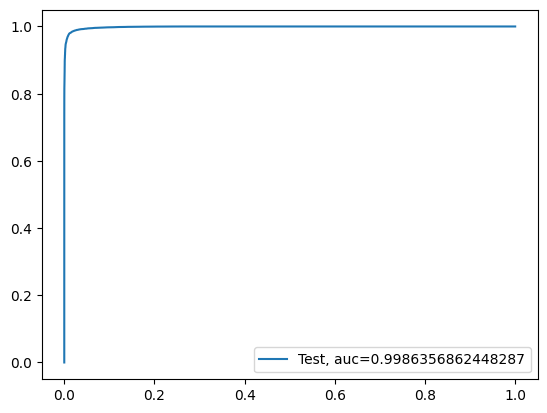

------------------------------------------------------------
Tempo gasto pelo modelo em Segundos: 24.64
Tempo gasto pelo modelo em Minutos: 0.41
Tempo gasto pelo modelo em Horas: 0.01
------------------------------------------------------------


In [34]:
# Radom Forest Model
import time
from sklearn.ensemble import RandomForestClassifier
print("Random Forest Model")
start_time = time.time()
df_Results = Random_Forest_Modelo(Results,"SMOTE COM RepeatedKFold Cross Validation",
                                          X_train_cv, y_train_cv, X_test_cv, y_test_cv)
segundos = round((time.time() - start_time),2)
minutos = round((time.time() - start_time) / 60, 2)
horas = round(((time.time() - start_time) / 60) / 60, 2)
print('-'*60 )
print("Tempo gasto pelo modelo em Segundos: %s" % segundos)
print("Tempo gasto pelo modelo em Minutos: %s" % minutos)
print("Tempo gasto pelo modelo em Horas: %s" % horas)
print('-'*60 )

In [35]:
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,SMOTE COM RepeatedKFold Cross Validation,Random Forest,0.983914,0.998636,0.61


In [36]:
df2 = df_Results

KNN Model
score do modelo
0.8918656697110036
Matrix de confusão
VN = VERDADEIRO NEGATIVO
FP = FALSO POSITIVO
FN = FALSO NEGATIVO
TP = VERDADEIRO POSITIVO


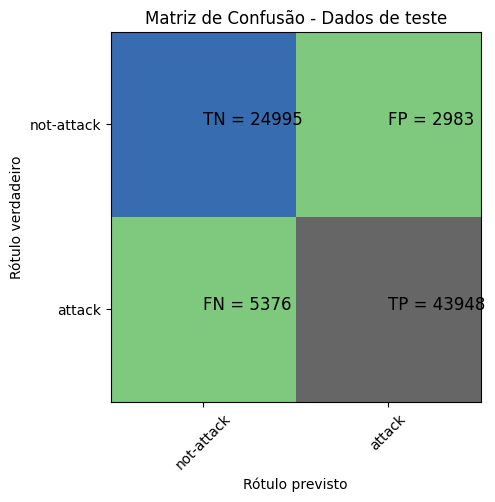

classification Report
              precision    recall  f1-score   support

           0       0.82      0.89      0.86     27978
           1       0.94      0.89      0.91     49324

    accuracy                           0.89     77302
   macro avg       0.88      0.89      0.88     77302
weighted avg       0.90      0.89      0.89     77302

KNN roc_value: 0.9656605070225623
KNN threshold: 0.6
ROC para o conjunto de dados de teste 96.6%


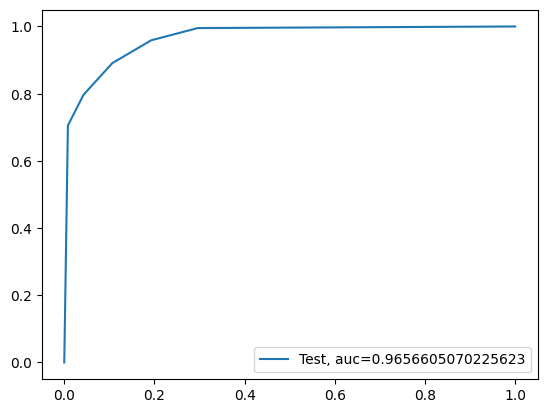

------------------------------------------------------------
Tempo gasto pelo modelo em Segundos: 69.18
Tempo gasto pelo modelo em Minutos: 1.15
Tempo gasto pelo modelo em Horas: 0.02
------------------------------------------------------------


In [37]:
import time
from sklearn.neighbors import KNeighborsClassifier
Data_Imbalance_Handiling = "SMOTE COM RepeatedKFold Cross Validation "
print("KNN Model")
start_time = time.time()
df_Results = KNN_Model(df_Results, Data_Imbalance_Handiling,X_train_SMOTE, y_train_SMOTE, X_test, y_test)
segundos = round((time.time() - start_time),2)
minutos = round((time.time() - start_time) / 60, 2)
horas = round(((time.time() - start_time) / 60) / 60, 2)
print('-'*60 )
print("Tempo gasto pelo modelo em Segundos: %s" % segundos)
print("Tempo gasto pelo modelo em Minutos: %s" % minutos)
print("Tempo gasto pelo modelo em Horas: %s" % horas)
print('-'*60 )

In [38]:
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,SMOTE COM RepeatedKFold Cross Validation,Random Forest,0.983914,0.998636,0.61
1,SMOTE COM RepeatedKFold Cross Validation,KNN,0.891866,0.965661,0.60


In [45]:
df5 = pd.merge(df1,df3,how = 'outer')

In [46]:
df5

,Methodology,Model,Accuracy,roc_value,threshold
0,SMOTE COM RepeatedKFold Cross Validation,XGBoost,0.988881,0.999392,0.546289
1,SMOTE COM RepeatedKFold Cross Validation,Random Forest,0.983914,0.998636,0.610000
2,SMOTE COM RepeatedKFold Cross Validation,KNN,0.891866,0.965661,0.600000
